# L2 penalised logistic regression model
Author: Roddy Jaques <br>
*NHS Blood and Transplant*
***

## Assessing the predictive ability of a Scikit learn logistic regression model with an L2 penalty 

This notebook repeats the process used to fit logistic regression models in the previous notebook, except the logistic regression model will be fit with an 'L2' penalisation.
<br>
First the data is imported and split into testing and training sets...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as mets
%matplotlib inline

# Function to print confusion matrix, balanced accuracy and accuracy for a set of actual and predicted labels
def show_metrics(actual,predict):
    """ Prints the confusion matrix, balanced accuracy and accuracy given datasets of actual and predicted labels
    
    Arguments:
        actual - Dataset of actual labels
        predict - Dataset of predicted labels
     """
    cm = mets.confusion_matrix(actual, predict)
    
    print("********* MODEL METRIC REPORT *********\n\nConfusion matrix:\n")

    print("TP  FN\nFP  TN\n") #this is a reminder of what each part of the confusion matrix means e.g. TP = True Positive
    
    # print the confusion matrix
    print(str(int(cm[0,0])) + "    " + str(int(cm[0,1])))
    print(str(int(cm[1,0])) + "    " + str(int(cm[1,1])) + "\n") 

    # classification report for DBD model
    print("Classification report:\n")
    print(mets.classification_report(actual, predict))

    print("Balanced accuracy: " + str(round(mets.balanced_accuracy_score(actual, predict),2)))

    print("Accuracy: " + str(round(mets.accuracy_score(actual, predict),2)))
    
    # Predicted vs actual consent rates
    cons_rate = int(100 * len(actual[actual=="Consent"]) / len(actual) )
    print("\nActual consent rate: " + str(cons_rate))
    
    pred_rate = int(100 * len(predict[predict=="Consent"]) / len(predict) )
    print("Predicted consent rate: " + str(pred_rate))
    
    pass
 
# Function to format consent column from integer code to text
def format_consent(x):
    if x == 2:
        return "Consent"
    if x == 1:
        return "Non-consent"

In [2]:
# Read in datasets 
dbd_model_data = pd.read_csv("Data/dbd_model_data.csv")
dcd_model_data = pd.read_csv("Data/dcd_model_data.csv")

# Columns used to create DBD model
dbd_cols = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "adult","FAMILY_CONSENT"]

dbd_model_data2 = pd.get_dummies(data=dbd_model_data,columns=dbd_cols[:-1],drop_first=True)

dbd_features = dbd_model_data2.drop("FAMILY_CONSENT",axis=1)
dbd_consents = dbd_model_data2["FAMILY_CONSENT"].apply(format_consent)

# Columns used to create DCD model in paper
dcd_cols = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "adult","cod_neuro","FAMILY_CONSENT"]

dcd_model_data2 = pd.get_dummies(data=dcd_model_data,columns=dcd_cols[:-1],drop_first=True)

dcd_features = dcd_model_data2.drop("FAMILY_CONSENT",axis=1)
dcd_consents = dcd_model_data2["FAMILY_CONSENT"].apply(format_consent)

# creating a train and testing dataset for DBD and DCD approaches
DBD_X_train, DBD_X_test, DBD_y_train, DBD_y_test = train_test_split(dbd_features,dbd_consents, test_size=0.33, random_state=10)

DCD_X_train, DCD_X_test, DCD_y_train, DCD_y_test = train_test_split(dcd_features,dcd_consents, test_size=0.33, random_state=10)

Now the logistic regression model is fit with the default solver, and uses an 'L2' penalisation. 

In [3]:
# fitting logistic regression to training data with L2 penatly
LR_model = LogisticRegression(penalty='l2')

In [4]:
DBD_LR = LR_model.fit(DBD_X_train,DBD_y_train)

DBD_preds = DBD_LR.predict(DBD_X_test)
DBD_prob= DBD_LR.predict_proba(DBD_X_test)

show_metrics(DBD_y_test, DBD_preds)

********* MODEL METRIC REPORT *********

Confusion matrix:

TP  FN
FP  TN

1262    120
367    251

Classification report:

              precision    recall  f1-score   support

     Consent       0.77      0.91      0.84      1382
 Non-consent       0.68      0.41      0.51       618

    accuracy                           0.76      2000
   macro avg       0.73      0.66      0.67      2000
weighted avg       0.74      0.76      0.74      2000

Balanced accuracy: 0.66
Accuracy: 0.76

Actual consent rate: 69
Predicted consent rate: 81


In [5]:
DCD_LR = LR_model.fit(DCD_X_train,DCD_y_train)

DCD_preds = DCD_LR.predict(DCD_X_test)
DCD_prob= DCD_LR.predict_proba(DCD_X_test)

show_metrics(DCD_y_test, DCD_preds)

********* MODEL METRIC REPORT *********

Confusion matrix:

TP  FN
FP  TN

1470    395
466    773

Classification report:

              precision    recall  f1-score   support

     Consent       0.76      0.79      0.77      1865
 Non-consent       0.66      0.62      0.64      1239

    accuracy                           0.72      3104
   macro avg       0.71      0.71      0.71      3104
weighted avg       0.72      0.72      0.72      3104

Balanced accuracy: 0.71
Accuracy: 0.72

Actual consent rate: 60
Predicted consent rate: 62


***
#### DBD model
The balanced accuracy has reduced by 0.01 with a penalisation compared to without penalisation, and the non-consent recall has reduced by 0.03. For the DBD model penalisation hasn't improved the model. 

#### DCD model
The DCD model metrics are unchanged by the penalisation.<br>

***
<br>

For consistency I plotted an ROC curve and calculated the AUC for the DBD and DCD models...

Text(0.5, 1.0, 'DBD and DCD ROC curves')

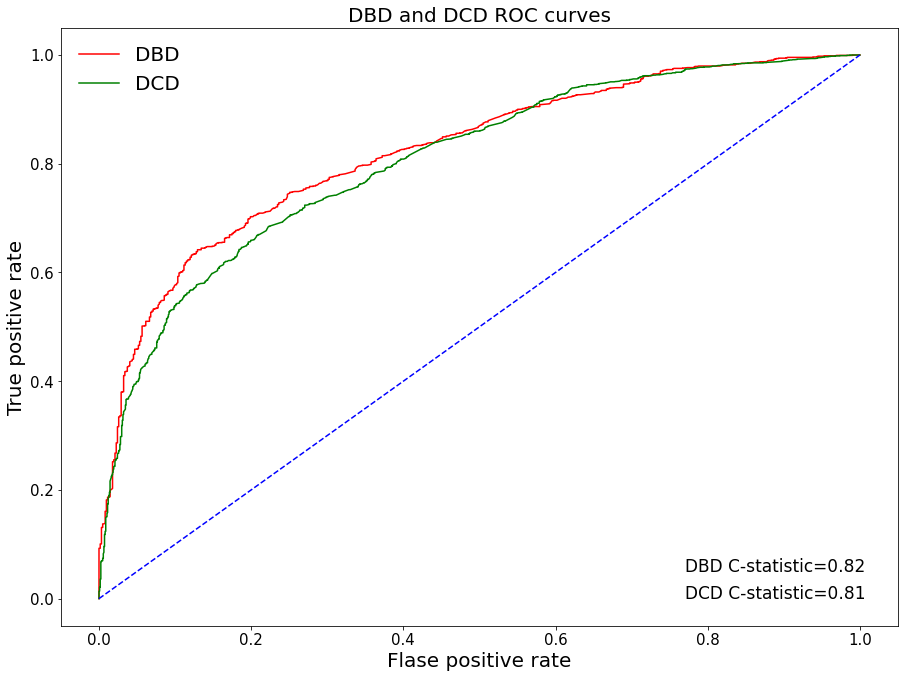

In [16]:
# ROC curve for both models
dbd_roc = mets.roc_curve(DBD_y_test, DBD_prob[:,0], pos_label="Consent")
dbd_auc = mets.roc_auc_score(DBD_y_test, DBD_prob[:,1])
dbd_c_stat = "DBD C-statistic=" + str(round(dbd_auc,2))

dcd_roc = mets.roc_curve(DCD_y_test, DCD_prob[:,0], pos_label="Consent")
dcd_auc = mets.roc_auc_score(DCD_y_test, DCD_prob[:,1])
dcd_c_stat = "DCD C-statistic=" + str(round(dcd_auc,2))


fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(dbd_roc[0],dbd_roc[1],"r")
ax.plot(dcd_roc[0],dcd_roc[1],"g")
ax.plot([0,1],[0,1],"--b")
ax.tick_params(axis="y",labelsize=15)
ax.tick_params(axis="x",labelsize=15)
ax.legend(["DBD","DCD"],loc="best",fontsize=20,frameon=False)

ax.text(0.77,0.05,dbd_c_stat, fontdict={'size':17, 'color':'black'})
ax.text(0.77,0,dcd_c_stat, fontdict={'size':17, 'color':'black'})

plt.xlabel("Flase positive rate",size=20)
plt.ylabel("True positive rate",size=20)
plt.title("DBD and DCD ROC curves",size=20)

The ROC curves are unchanged from the unpenalised logistic regression models, consistent with the other metrics for these models.<br>
***
To see if the strength of penalisation will change the metrics, models are run with different penalisation strengths and the recall for each class is calculated and the balanced accuracy is too.

## Tuning L2 penalisation parameter

Text(0.5, 1.0, 'Effect of penalisation strength on DBD model metrics')

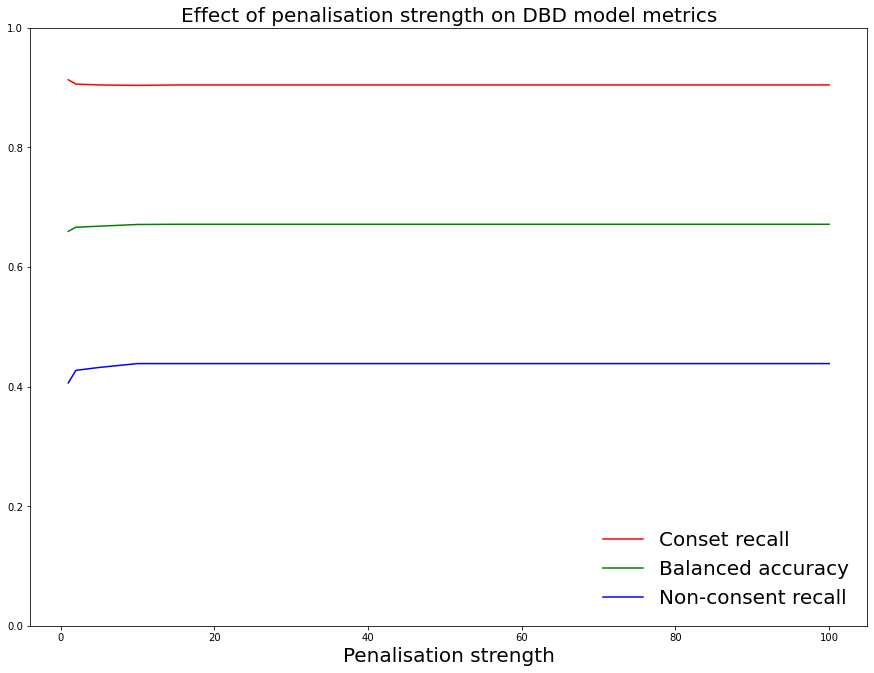

In [19]:
# Penalisation strengths to be tested 
cs = [1,2,5,10,15,20,30,40,100]

# Empty arrays to for balanced accuracy and recall for each class at each penalisation strength
recall_cons = []
recall_refs = []
bas = []

# fit models with different penalisation strengths
for c in cs:
    LR_model = LogisticRegression(penalty='l2',C=c)
    DBD_LR = LR_model.fit(DBD_X_train,DBD_y_train)
    DBD_preds = DBD_LR.predict(DBD_X_test)
    recall_cons.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label="Consent"))
    recall_refs.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label="Non-consent"))
    bas.append(mets.balanced_accuracy_score(DBD_y_test,DBD_preds))

# plot metrics against penalisation strength
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(cs,recall_cons,"r")
ax.plot(cs,bas,"g")
ax.plot(cs,recall_refs,"b")
plt.xlabel("Penalisation strength",size=20)
ax.legend(["Conset recall","Balanced accuracy","Non-consent recall"],loc=4,fontsize=20,frameon=False)
ax.set_ylim([0,1])

plt.title("Effect of penalisation strength on DBD model metrics",size=20)

Text(0.5, 1.0, 'Effect of penalisation strength on DCD model metrics')

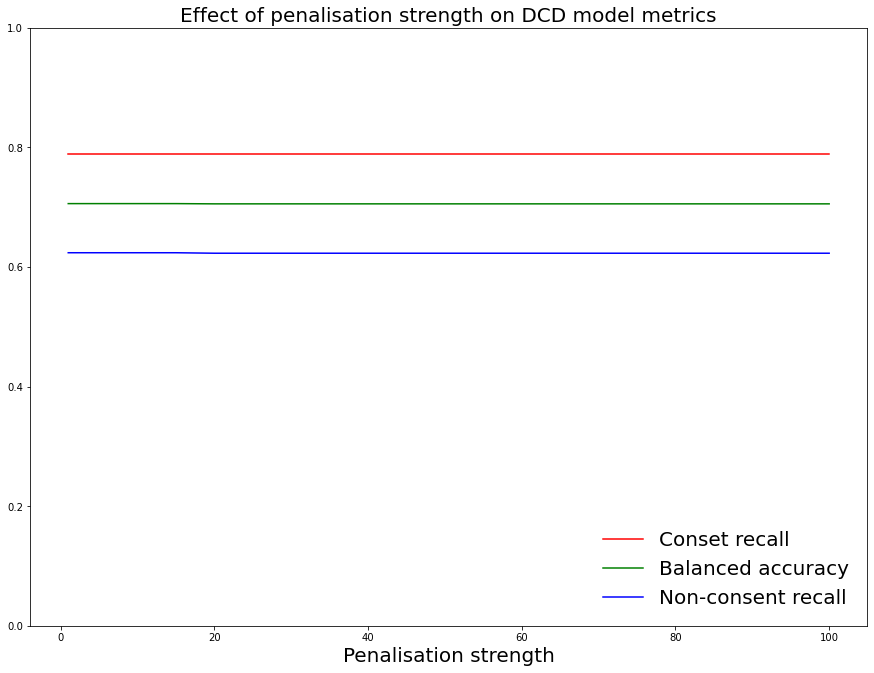

In [20]:
# Penalisation strengths to be tested 
cs = [1,2,5,10,15,20,30,40,100]

# Empty arrays to for balanced accuracy and recall for each class at each penalisation strength
recall_cons = []
recall_refs = []
bas = []

# fit models with different penalisation strengths
for c in cs:
    LR_model = LogisticRegression(penalty='l2',C=c)
    DCD_LR = LR_model.fit(DCD_X_train,DCD_y_train)
    DCD_preds = DCD_LR.predict(DCD_X_test)
    recall_cons.append(mets.recall_score(DCD_y_test,DCD_preds,pos_label="Consent"))
    recall_refs.append(mets.recall_score(DCD_y_test,DCD_preds,pos_label="Non-consent"))
    bas.append(mets.balanced_accuracy_score(DCD_y_test,DCD_preds))

# plot metrics against penalisation strengths
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(cs,recall_cons,"r")
ax.plot(cs,bas,"g")
ax.plot(cs,recall_refs,"b")
plt.xlabel("Penalisation strength",size=20)
ax.legend(["Conset recall","Balanced accuracy","Non-consent recall"],loc=4,fontsize=20,frameon=False)
ax.set_ylim([0,1])
plt.title("Effect of penalisation strength on DCD model metrics",size=20)

Changing the penalisation strength for the DCD model has no effect on any of the metrics.<br> 
For the DBD model the balanced accuracy and non-consent recall are lower at small penalisation strengths before levelling off.<br>
***
Adding L2 regularisation to the models has not improved their ability to predict family consent for organ donation. To improve on the baseline logisitic regression other models will be explored. In the next notebook a decision tree model will be fit and compared to the baseline model metrics. 
***